In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from tabulate import tabulate
from itertools import product

# Modelos de Machine Learning
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Model Selection y Validación
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)

# Métricas
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)


In [3]:
# Cargar el archivo CSV limpio
data_limpia = pd.read_csv('../data/data_limpia.csv')

# Ver las primeras filas del DataFrame para confirmar que se ha cargado correctamente
data_limpia.head()

,CODE,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
0,0,0,0,0,1,1,0,0,1,1,...,2,0,2,1,2892,0,0,2,18,0
1,11111,0,0,0,1,1,0,0,0,1,...,2,1,3,0,1376,7187,0,2,53,0
2,22222,0,0,0,1,1,3,0,1,1,...,1,0,3,0,1376,0,1,4,21,3
3,33333,0,0,0,1,1,2,0,0,1,...,1,1,2,1,2015,7256,1,4,48,5
4,53605,0,0,0,1,1,2,0,0,1,...,1,1,1,0,2015,11293,0,2,56,0


In [4]:
# Definir las características (features) y el objetivo (target)
X = data_limpia.drop(columns=['Mas_1_coche', 'Tiempo',"CODE"])  # Eliminamos también la columna 'Tiempo'
y = data_limpia['Mas_1_coche']  # Objetivo (si el cliente comprará un segundo coche)


In [5]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Definir los parámetros para la búsqueda de Grid
param_grid = {
    'criterion': ['entropy'],  
    'max_depth': [16, 20],  
    'min_samples_split': [8, 10,15],  
    'min_samples_leaf': [3],  
    'n_estimators': [500],  
}

# Almacenar los resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, max_depth, min_samples_split, min_samples_leaf, n_estimators = params
    
    # Construir el modelo RandomForest con class_weight='balanced'
    model = RandomForestClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        class_weight='balanced',  # <-- Agregado para mejorar recall
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    y_pred = (y_pred_proba > 0.4).astype(int)  # <-- Ajustar umbral de decisión (antes era 0.5)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  # <-- Enfocarse en recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  # <-- Optimizar recall
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  # <-- Priorizar recall
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  # <-- Guardar recall en validación cruzada
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))


,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,accuracy,f1_score,recall,roc_auc,cv_recall
0,entropy,18,7,3,500,0.832232,0.838713,0.832232,0.937269,0.820423


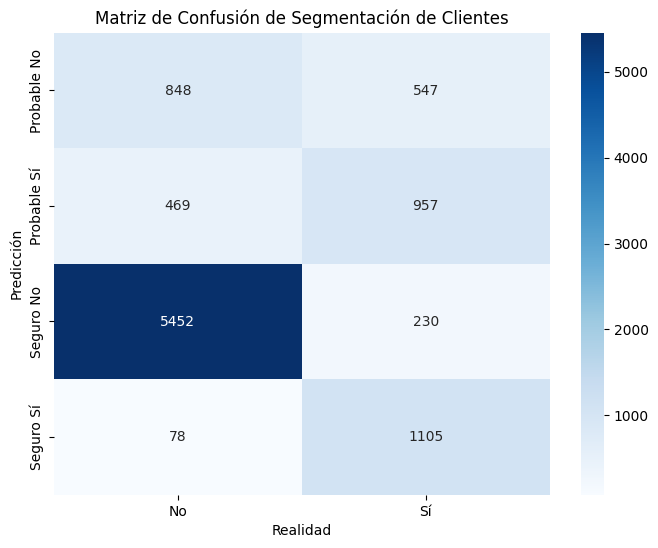

Realidad       No    Sí
Predicción             
Probable No   848   547
Probable Sí   469   957
Seguro No    5452   230
Seguro Sí      78  1105


In [ ]:
# Definir los parámetros para la búsqueda de Grid
param_grid = {
    'criterion': ['entropy'],  
    'max_depth': [18],  
    'min_samples_split': [7],  
    'min_samples_leaf': [3],  
    'n_estimators': [500],  
}

# Almacenar los resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, max_depth, min_samples_split, min_samples_leaf, n_estimators = params
    
    # Construir el modelo RandomForest con class_weight='balanced'
    model = RandomForestClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        class_weight='balanced',  # <-- Agregado para mejorar recall
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    y_pred = (y_pred_proba > 0.4).astype(int)  # <-- Ajustar umbral de decisión (antes era 0.5)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  # <-- Enfocarse en recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  # <-- Optimizar recall
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  # <-- Priorizar recall
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  # <-- Guardar recall en validación cruzada
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))



In [ ]:
# Obtener las probabilidades de compra en el dataset nuevo
y_proba_frescos = best_xgb.predict_proba(X)[:, 1]

# Clasificar los nuevos datos según los umbrales
y_pred_frescos = np.array([categorize_customers(p) for p in y_proba_frescos])

# Contar las frecuencias de cada categoría en los datos predecidos
pred_counts = results_df_xgb["Predicción"].value_counts().sort_index()

# Contar las frecuencias de cada categoría en los datos frescos
fresh_counts = pd.Series(y_pred_frescos).value_counts().sort_index()

# Crear el histograma
plt.figure(figsize=(10, 6))
sns.barplot(x=pred_counts.index, y=pred_counts.values, color='blue', alpha=0.6, label="Predicciones")
plt.plot(fresh_counts.index, fresh_counts.values, marker='o', color='red', linestyle='-', linewidth=2, label="Datos frescos")

# Configurar etiquetas y título
plt.xlabel("Categoría de Predicción")
plt.ylabel("Frecuencia")
plt.title("Histograma de Predicciones vs Datos Frescos")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

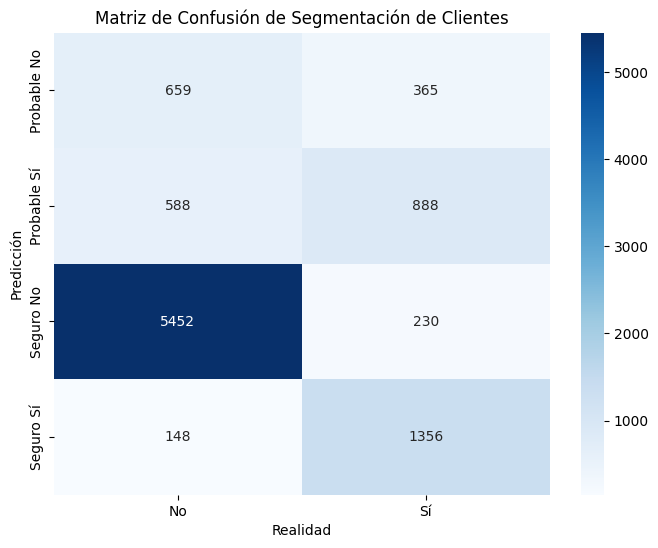

Realidad       No    Sí
Predicción             
Probable No   659   365
Probable Sí   588   888
Seguro No    5452   230
Seguro Sí     148  1356


In [11]:

# Umbrales ajustables
umbral_seguro_si = 0.75
umbral_probable_si = 0.55
umbral_probable_no = 0.40

# Obtener el mejor modelo de RandomForest según recall
best_rf_params = results_df.iloc[0][['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators']].to_dict()

best_rf = RandomForestClassifier(
    criterion=best_rf_params['criterion'],
    max_depth=int(best_rf_params['max_depth']),
    min_samples_split=int(best_rf_params['min_samples_split']),
    min_samples_leaf=int(best_rf_params['min_samples_leaf']),
    n_estimators=int(best_rf_params['n_estimators']),
    class_weight='balanced',
    random_state=42
)

# Entrenar el mejor modelo
best_rf.fit(X_train, y_train)

# Obtener probabilidades de compra
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]


# Función para categorizar clientes según probabilidades
def categorize_customers(prob):
    if prob >= umbral_seguro_si:
        return "Seguro Sí"
    elif prob >= umbral_probable_si:
        return "Probable Sí"
    elif prob >= umbral_probable_no:
        return "Probable No"
    else:
        return "Seguro No"

# Aplicar la categorización
y_pred_categories_rf = np.array([categorize_customers(p) for p in y_pred_proba_rf])

# Crear DataFrame con predicciones y realidad
results_df_rf = pd.DataFrame({
    "Predicción": y_pred_categories_rf,
    "Realidad": y_test.map({1: "Sí", 0: "No"})  # Convertir valores 1/0 en Sí/No
})

# Crear matriz de confusión para visualizar mejor
conf_matrix = pd.crosstab(results_df_rf["Predicción"], results_df_rf["Realidad"], rownames=["Predicción"], colnames=["Realidad"])

# Mostrar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusión de Segmentación de Clientes")
plt.show()

# Mostrar los datos en tabla
print(conf_matrix)


In [ ]:
# Definir los parámetros para la búsqueda de Grid
param_grid = {
    'criterion': ['entropy'],  
    'max_depth': [21,23],  
    'min_samples_split': [9, 12, 14],  
    'min_samples_leaf': [3],  
    'n_estimators': [500],  
}

# Almacenar los resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, max_depth, min_samples_split, min_samples_leaf, n_estimators = params
    
    # Construir el modelo RandomForest con class_weight='balanced'
    model = RandomForestClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        class_weight='balanced',  # <-- Agregado para mejorar recall
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    y_pred = (y_pred_proba > 0.4).astype(int)  # <-- Ajustar umbral de decisión (antes era 0.5)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  # <-- Enfocarse en recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  # <-- Optimizar recall
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  # <-- Priorizar recall
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  # <-- Guardar recall en validación cruzada
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))




,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,accuracy,f1_score,recall,roc_auc,cv_recall
3,entropy,23,9,3,500,0.839872,0.845797,0.839872,0.939505,0.813812
0,entropy,21,9,3,500,0.836878,0.843033,0.836878,0.939189,0.817475
1,entropy,21,12,3,500,0.833987,0.840403,0.833987,0.939095,0.829358
4,entropy,23,12,3,500,0.833471,0.839932,0.833471,0.939335,0.825695
2,entropy,21,14,3,500,0.832542,0.839135,0.832542,0.938979,0.833646


In [ ]:
# Definir los parámetros para la búsqueda de Grid
param_grid = {
    'criterion': ['entropy'],  
    'max_depth': [22],  
    'min_samples_split': [9, 12],  
    'min_samples_leaf': [3],  
    'n_estimators': [300,400],  
}

# Almacenar los resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, max_depth, min_samples_split, min_samples_leaf, n_estimators = params
    
    # Construir el modelo RandomForest con class_weight='balanced'
    model = RandomForestClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        class_weight='balanced',  # <-- Agregado para mejorar recall
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    y_pred = (y_pred_proba > 0.4).astype(int)  # <-- Ajustar umbral de decisión (antes era 0.5)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  # <-- Enfocarse en recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  # <-- Optimizar recall
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  # <-- Priorizar recall
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  # <-- Guardar recall en validación cruzada
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))


,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,accuracy,f1_score,recall,roc_auc,cv_recall
1,entropy,22,9,3,400,0.839253,0.845255,0.839253,0.939855,0.814258
0,entropy,22,9,3,300,0.838840,0.844882,0.838840,0.939805,0.814705
3,entropy,22,12,3,400,0.834503,0.840885,0.834503,0.939340,0.826678
2,entropy,22,12,3,300,0.833574,0.839995,0.833574,0.939201,0.826499


,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,accuracy,f1_score,recall,roc_auc,cv_recall
0,entropy,23,10,3,200,0.838117,0.844225,0.838117,0.939868,0.818190
2,entropy,23,13,3,200,0.832955,0.839450,0.832955,0.938772,0.826767
1,entropy,23,10,6,200,0.824902,0.832029,0.824902,0.936161,0.840882
3,entropy,23,13,6,200,0.823870,0.831100,0.823870,0.935927,0.842848


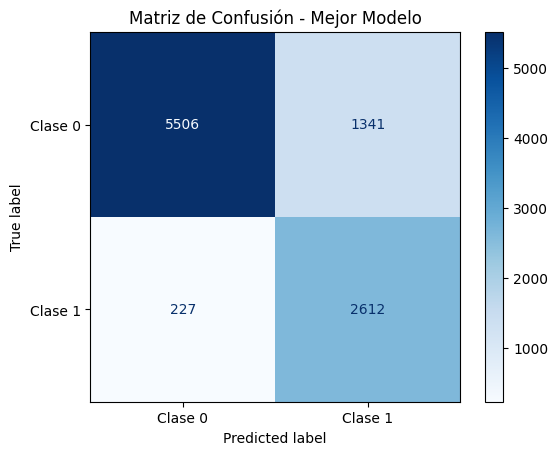

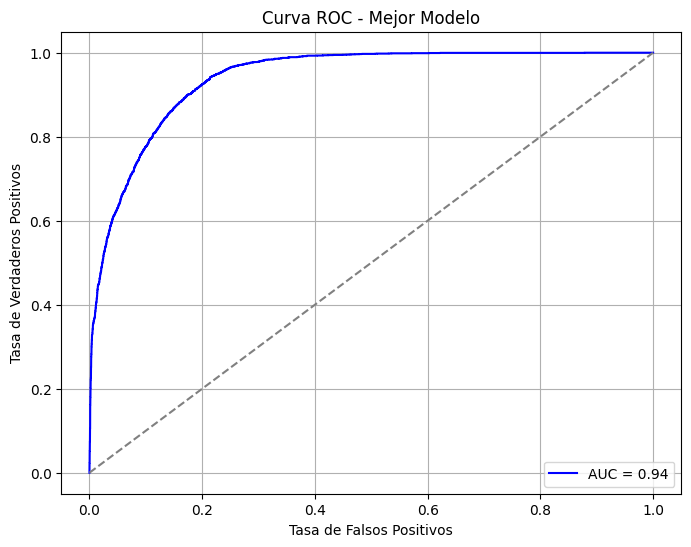

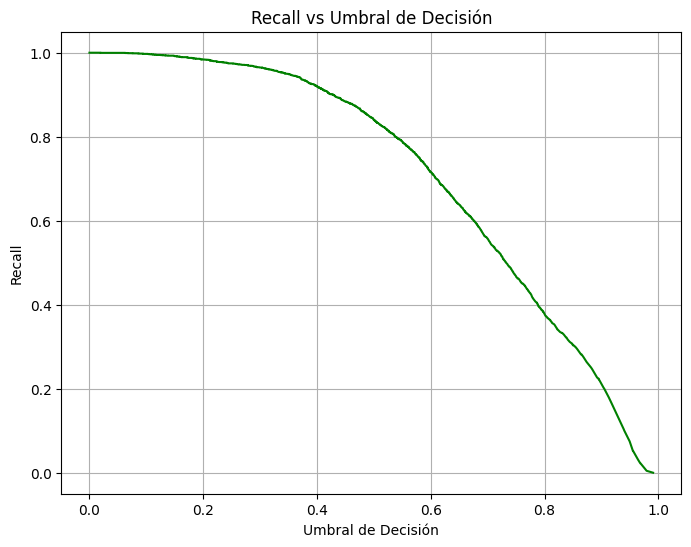

In [ ]:

# Definir los parámetros para la búsqueda de Grid
param_grid = {
    'criterion': ['entropy'],  
    'max_depth': [23],  
    'min_samples_split': [10, 13],  
    'min_samples_leaf': [3,6],  
    'n_estimators': [200],  
}

# Almacenar los resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, max_depth, min_samples_split, min_samples_leaf, n_estimators = params
    
    # Construir el modelo RandomForest con class_weight='balanced'
    model = RandomForestClassifier(
        criterion=criterion, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        class_weight='balanced',  # <-- Agregado para mejorar recall
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    y_pred = (y_pred_proba > 0.4).astype(int)  # <-- Ajustar umbral de decisión (antes era 0.5)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')  # <-- Enfocarse en recall
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')  # <-- Optimizar recall
    mean_cv_score = np.mean(cv_scores)
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'n_estimators': n_estimators,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,  # <-- Priorizar recall
        'roc_auc': roc_auc,
        'cv_recall': mean_cv_score  # <-- Guardar recall en validación cruzada
    })

# Convertir a DataFrame y ordenar por recall
results_df = pd.DataFrame(results).sort_values(by=['recall', 'f1_score'], ascending=False)

# Mostrar los mejores modelos optimizados para recall
display(results_df.head(5))

# Obtener el mejor modelo
best_model_params = results_df.iloc[0]
best_model = RandomForestClassifier(
    criterion=best_model_params['criterion'], 
    max_depth=best_model_params['max_depth'], 
    min_samples_split=best_model_params['min_samples_split'], 
    min_samples_leaf=best_model_params['min_samples_leaf'],
    n_estimators=best_model_params['n_estimators'],
    class_weight='balanced',
    random_state=42
)

# Entrenar el mejor modelo
best_model.fit(X_train, y_train)

# Obtener las probabilidades de predicción
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.4).astype(int)  # Ajuste del umbral

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión - Mejor Modelo')
plt.show()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title(f'Curva ROC - Mejor Modelo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Graficar Recall vs Umbral de decisión
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='Recall', color='green')
plt.title('Recall vs Umbral de Decisión')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Recall')
plt.grid(True)
plt.show()
